In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.8.2


# 1. Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

# Global Variables
RAW_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/New_Raw_Dataset"
CLEAN_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Clean_Dataset"
TRAIN_PATH = os.path.join(CLEAN_DATASET_PATH, 'train')
DEV_PATH = os.path.join(CLEAN_DATASET_PATH, 'dev')
# TEST_PATH = os.path.join(DATASET_SPLIT_PATH, 'test')
NUM_OF_PLANTS = len(os.listdir(RAW_DATASET_PATH))

print('Total jenis tanaman herbal:', NUM_OF_PLANTS)

Total jenis tanaman herbal: 18


In [4]:
from tensorflow.keras.utils import image_dataset_from_directory as IMFD

LABEL_MODE = 'categorical' # Use categorical_crossentropy loss function
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

def CreateTrainValGenerator(train_path, dev_path, label_mode, color_mode, batch_size, image_size, seed):
  train_ds = IMFD(
                    train_path,
                    label_mode=label_mode,
                    color_mode=color_mode,
                    batch_size=batch_size,
                    image_size=image_size,
                    seed=seed,
                  )

  val_ds = IMFD(
                  dev_path,
                  label_mode=label_mode,
                  color_mode=color_mode,
                  batch_size=batch_size,
                  image_size=image_size,
                  seed=seed,
                )
  
  return train_ds, val_ds

train_ds, val_ds = CreateTrainValGenerator(TRAIN_PATH, DEV_PATH, LABEL_MODE, COLOR_MODE, BATCH_SIZE, IMAGE_SIZE, SEED)
plant_names = train_ds.class_names
print('\nClass Names:\n{}'.format(plant_names))

Found 1085 files belonging to 18 classes.
Found 466 files belonging to 18 classes.

Class Names:
['Andong', 'Bayam Duri', 'Binahong', 'Cincau Hijau', 'Jeruk Nipis', 'Kelor', 'Kemangi', 'Kumis Kucing', 'Meniran', 'Mint', 'Pandan', 'Pepaya', 'Sambiloto', 'Sembung', 'Serai', 'Singkong', 'Sirih', 'Talas']


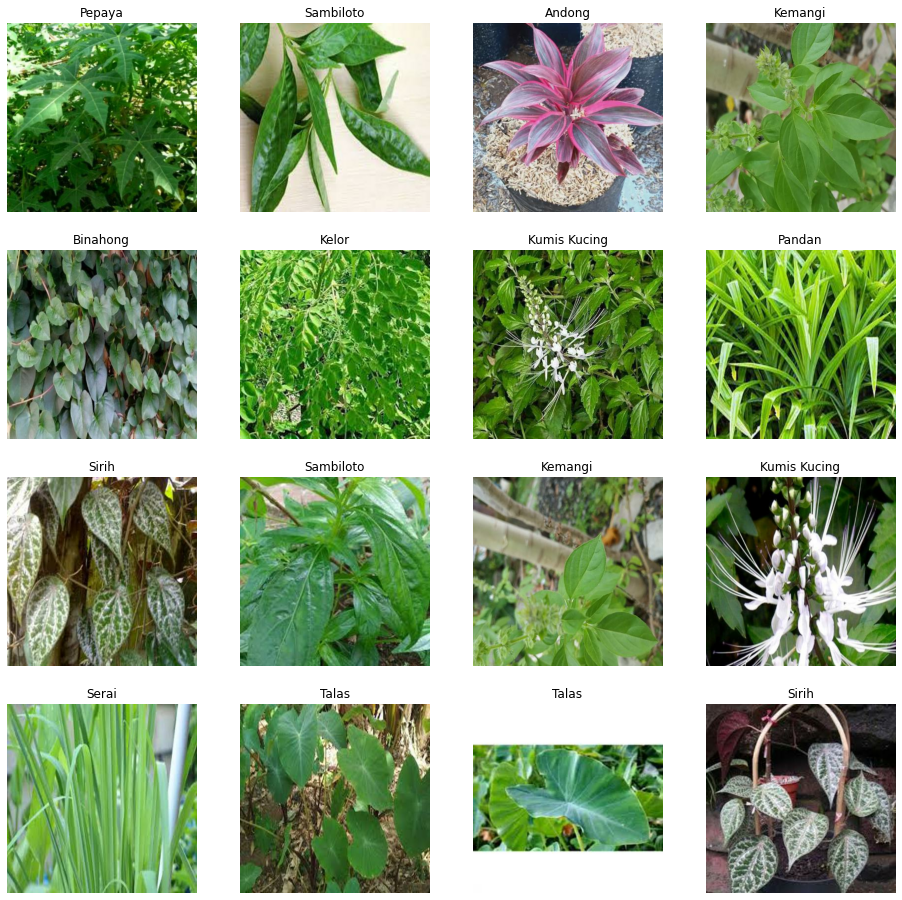

In [5]:
import matplotlib.pyplot as plt

def PlotDatasetBatchImages(dataset, plants_list): 
  plt.figure(figsize=(16, 16)) 
  for images, labels in dataset.take(1):
    for i in range(16): # Minimum 16 BATCH_SIZE, if less change accordingly
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_index = np.argmax(labels[i]) # One-hot encoding
      plt.title(plants_list[class_index])
      plt.axis("off")

PlotDatasetBatchImages(train_ds, plant_names)

In [6]:
# Check Shape per batch

for image_batch, labels_batch in train_ds:
  print('Batch Image Shape:', image_batch.shape)
  print('Batch Labels Shape:', labels_batch.shape)
  break

Batch Image Shape: (32, 384, 384, 3)
Batch Labels Shape: (32, 18)


In [7]:
# Preprocessing Sequential Layers

RESCALE = tf.keras.Sequential([
                                keras.layers.Rescaling(1./255)
                              ])

AUGMENT_DATA = tf.keras.Sequential([
                                keras.layers.RandomFlip("horizontal"),
                                keras.layers.RandomRotation(
                                                             (-0.2, 0.2),
                                                             fill_mode='reflect',
                                                             interpolation='bilinear'),
                                keras.layers.RandomTranslation(
                                                                (-0.15, 0.15),
                                                                (-0.15, 0.15),
                                                                fill_mode='reflect',
                                                                interpolation='bilinear'),
                              ])

def prepare(ds, augment=False):
  # Rescale all datasets
  ds = ds.map(lambda x, y: (RESCALE(x), y))

  # Data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (AUGMENT_DATA(x, training=True), y))

  return ds

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

# 2. Model Building

In [8]:
# EfficientNetV2 Base Model

INPUT_SHAPE = (384, 384, 3)

def CreateBaseModel(input_shape):
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                                                                      include_top=False,
                                                                      weights='imagenet',
                                                                      input_shape=input_shape,
                                                                      include_preprocessing=False
                                                                    )
  base_model.trainable = False
  return base_model

base_model = CreateBaseModel(INPUT_SHAPE)

In [9]:
# Functional API for Keras Model Building

def CreateFinalModel(base_model, input_shape, num_of_plants):
  inputs = keras.Input(shape=input_shape)
    
  # Base Model Instantiation
  x = base_model(inputs, training=False)

  # Custom DNN Model
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dropout(0.6)(x)
  x = keras.layers.Dense(320, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)

  outputs = keras.layers.Dense(num_of_plants, activation='softmax')(x)

  final_model = keras.Model(inputs, outputs)
  return final_model

final_model = CreateFinalModel(base_model, INPUT_SHAPE, NUM_OF_PLANTS)
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 640)               819840    
                                                                 
 dropout (Dropout)           (None, 640)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               205120

In [10]:
LR = 1e-4

final_model.compile(optimizer = keras.optimizers.Adam(learning_rate=LR), 
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [11]:
# Callback for validation accuracy stopping

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print("\nReached 99% validation accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [12]:
EPOCHS = 100

history = final_model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
34/34 [==============================] - 70s 2s/step - loss: 2.8227 - accuracy: 0.1346 - val_loss: 2.5523 - val_accuracy: 0.3562
Epoch 2/100
34/34 [==============================] - 50s 1s/step - loss: 2.5012 - accuracy: 0.2959 - val_loss: 2.2156 - val_accuracy: 0.4464
Epoch 3/100
34/34 [==============================] - 50s 1s/step - loss: 2.1622 - accuracy: 0.4194 - val_loss: 1.8522 - val_accuracy: 0.5236
Epoch 4/100
34/34 [==============================] - 50s 1s/step - loss: 1.8528 - accuracy: 0.5134 - val_loss: 1.5370 - val_accuracy: 0.6159
Epoch 5/100
34/34 [==============================] - 49s 1s/step - loss: 1.5976 - accuracy: 0.5889 - val_loss: 1.2776 - val_accuracy: 0.6760
Epoch 6/100
34/34 [==============================] - 50s 1s/step - loss: 1.3535 - accuracy: 0.6525 - val_loss: 1.1074 - val_accuracy: 0.6953
Epoch 7/100
34/34 [==============================] - 50s 1s/step - loss: 1.1995 - accuracy: 0.6562 - val_loss: 0.9733 - val_accuracy: 0.7554
Epoch 8/100
3

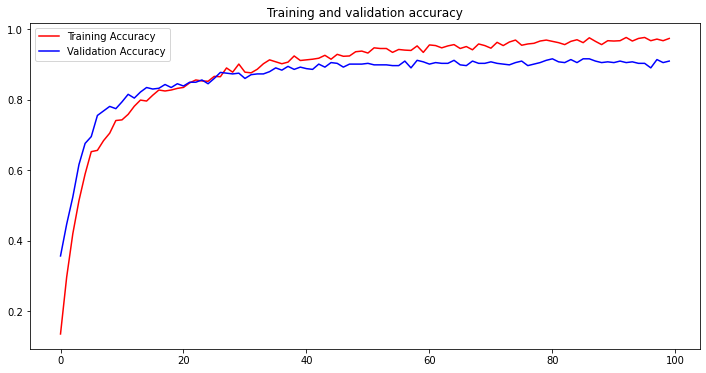

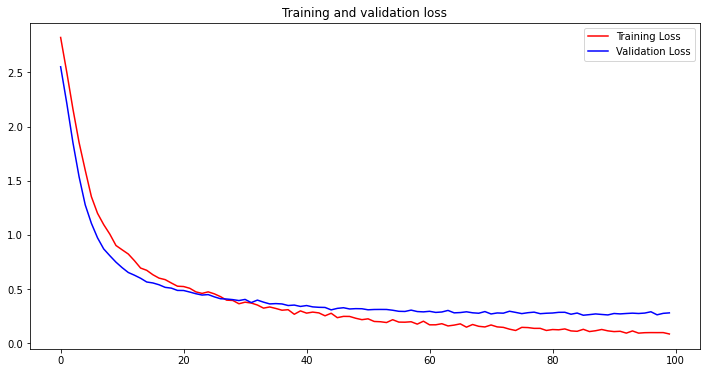

In [21]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('Training and validation accuracy')
plt.show()

print("")
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(12, 6)) 
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training Loss", "Validation Loss"])
plt.title('Training and validation loss')
plt.show()

# 3. Model Evaluation and Uploaded Image Testing

In [14]:
# Testing Dataset currently unavailable

# final_model.evaluate(test_ds)

In [22]:
# Preprocess Data for model prediction input
from PIL import Image
from numpy import asarray

def PreprocessImageAsArray(path, show_output):
  im = Image.open(path).convert('RGB')
  im = im.resize((384, 384))
  image_as_array = np.expand_dims(asarray(im), axis=0)
  scaled_image_as_array = np.true_divide(image_as_array, 255)
  
  if show_output:
    print('Gambar {} selesai di proses.'.format(path))
    print('Shape: {}\n'.format(scaled_image_as_array.shape))
  return scaled_image_as_array

def PreprocessDanPrediksi(image_path, show_output=True):
  image_as_array = PreprocessImageAsArray(image_path, show_output)
  pred = final_model.predict(image_as_array)
  sorted_ranks = np.flip(np.argsort(pred[0]))
  
  if show_output:
    rank = 1
    print('Prediksi Tanaman:')
    for plant_rank in sorted_ranks:
      print('{:2}. {:16}: {:.3f}'.format(rank, plant_names[plant_rank], pred[0][plant_rank]))
      rank += 1

In [23]:
# Try out model with uploaded images
from google.colab import files
uploaded = files.upload()

Saving pepaya custom.jpeg to pepaya custom.jpeg


In [24]:
IMAGE_PATH = "/content/pepaya custom.jpeg"
PreprocessDanPrediksi(IMAGE_PATH)

Gambar /content/pepaya custom.jpeg selesai di proses.
Shape: (1, 384, 384, 3)

Prediksi Tanaman:
 1. Pepaya          : 0.387
 2. Singkong        : 0.385
 3. Meniran         : 0.220
 4. Sembung         : 0.003
 5. Kumis Kucing    : 0.002
 6. Talas           : 0.001
 7. Kelor           : 0.001
 8. Jeruk Nipis     : 0.001
 9. Cincau Hijau    : 0.000
10. Sambiloto       : 0.000
11. Andong          : 0.000
12. Bayam Duri      : 0.000
13. Pandan          : 0.000
14. Kemangi         : 0.000
15. Serai           : 0.000
16. Mint            : 0.000
17. Sirih           : 0.000
18. Binahong        : 0.000


In [25]:
# Benchmark Prediction Time
%timeit PreprocessDanPrediksi(IMAGE_PATH, show_output=False)

10 loops, best of 5: 136 ms per loop


# 4. Final Model Saving (Saved Model Format)


In [26]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 40 kB 6.4 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [27]:
from datetime import datetime
import tensorflowjs as tfjs
import shutil
now = datetime.now()
now_converted = now.strftime("%d-%m-%Y_%H.%M.%S")
final_zip_path = '/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Model_Storage/herbapedia_model_{}'.format(now_converted)
tfjs_target_dir = './output/'

tfjs.converters.save_keras_model(final_model, tfjs_target_dir)
shutil.make_archive(final_zip_path, 'zip', tfjs_target_dir)

'/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Model_Storage/herbapedia_model_11-06-2022_10.23.22.zip'